# Today's NEO Appearances

In this session we compute the overall statistics of the current NEO populations' brightness. We'll see that we have a few weird outliers and compare their "detectability" with a generic property of the NEO survey telescope Pan-Starrs.

In [1]:
# Standard libraries
import datetime
import math
import pathlib
import sqlite3
import sys

# Installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spiceypy

# Append to root directory of this repository
sys.path.append("../")

# Auxiliary module that contains the apparent magnitude
from auxiliary import photometry

In [2]:
# Accessing the NEO database
database_dir = pathlib.Path("../databases/neos/")
database_file = pathlib.Path("neodys.db")
database_filepath = database_dir / database_file

# Establish a connection to the database and set a cursor
neodys_db_con = sqlite3.connect(database_filepath)
neodys_db_cur = neodys_db_con.cursor()

In [3]:
# Get all information from the DB. Since the DB is rather small, this won't cause any issues!
neo_df = pd.read_sql("SELECT * FROM main", neodys_db_con)

# Close the database.
neodys_db_con.close()

In [4]:
neo_df

,Name,Epoch_MJD,SemMajAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,MeanAnom_deg,AbsMag_,SlopeParamG_,Aphel_AU,Perihel_AU,NEOClass
0,433,59600.0,1.458273,0.222727,10.828461,304.296346,178.897177,246.904119,10.87,0.46,1.783070,1.133476,Amor
1,719,59600.0,2.637505,0.546959,11.575272,183.855259,156.227573,278.197185,15.53,0.15,4.080112,1.194899,Amor
2,887,59600.0,2.473158,0.570486,9.394141,110.428769,350.493276,86.607207,13.33,-0.12,3.884060,1.062256,Amor
3,1036,59600.0,2.665849,0.533122,26.677908,215.517191,132.428118,140.654843,9.41,0.30,4.087071,1.244627,Amor
4,1221,59600.0,1.918731,0.435843,11.883264,171.320251,26.643922,261.044505,17.40,0.15,2.754996,1.082467,Amor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29044,2022KY2,59600.0,1.439076,0.290852,9.562666,220.831102,344.748373,308.992894,24.82,0.15,1.857634,1.020519,Amor
29045,2022KZ,59600.0,1.404505,0.389038,10.755270,64.554335,243.245936,257.305079,26.44,0.15,1.950911,0.858099,Apollo
29046,2022KZ1,59600.0,1.643745,0.562916,31.322592,63.673736,262.310279,276.670518,26.14,0.15,2.569035,0.718455,Apollo
29047,2022KZ2,59600.0,1.342108,0.412424,13.556790,237.807367,283.141272,319.777066,26.25,0.15,1.895626,0.788590,Apollo


In [5]:
# Load SPICE kernels
spiceypy.furnsh("../kernels/spk/de432s.bsp")
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/pck/gm_de431.tpc")

# Get the G*M value of the Sun
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
gm_sun = gm_sun_pre[0]

In [6]:
# Determine today's datetime
curr_time_et = spiceypy.utc2et(datetime.datetime.now().strftime("%Y-%m-%d"))

In [7]:
sun2earth_position_vec = spiceypy.spkgps(targ=399,
                                     et=curr_time_et,
                                     ref="ECLIPJ2000",
                                     obs=10)[0]
sun2earth_position_vec

array([ 1.50093320e+08,  1.64316490e+06, -1.29773492e+03])

In [8]:
# For our computations we need to convert some values from AU to km and from deg to rad
neo_df.loc[:, "Perihel_km"] = neo_df["Perihel_AU"].apply(lambda x: spiceypy.convrt(x, "AU", "km"))
neo_df.loc[:, "Incl_rad"] = neo_df["Incl_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "LongAscNode_rad"] = neo_df["LongAscNode_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "ArgP_rad"] = neo_df["ArgP_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "MeanAnom_rad"] = neo_df["MeanAnom_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "Epoch_JD"] = neo_df["Epoch_MJD"].apply(lambda x: x + 2400000.5)
neo_df.loc[:, "Epoch_et"] = neo_df["Epoch_JD"].apply(lambda x: spiceypy.utc2et(str(x) + " JD"))

In [9]:
# Compute the position vector of each NEO as seen from the Sun
neo_df.loc[:, "sun2neo_position_vec"] = \
    neo_df.apply(lambda x: spiceypy.conics(elts=[x["Perihel_km"],
                                                 x["Ecc_"],
                                                 x["Incl_rad"],
                                                 x["LongAscNode_rad"],
                                                 x["ArgP_rad"],
                                                 x["MeanAnom_rad"],
                                                 x["Epoch_et"],
                                                 gm_sun],
                                         et=curr_time_et)[:3],
                 axis=1)

In [10]:
# Let's take the position value of (433) Eros and compare it with NASA Horizons
neo_df.iloc[0]["sun2neo_position_vec"]

array([-1.66166744e+08,  5.62640353e+07, -2.01934353e+07])

In [11]:
# To compute the apparent magnitude we need to re-compute the positional vectors and convert it to
# AU
neo_df.loc[:, "neo2earth_position_vec"] = \
    neo_df["sun2neo_position_vec"].apply(lambda x: sun2earth_position_vec - x)
neo_df.loc[:, "neo2sun_position_vec"] = \
    neo_df["sun2neo_position_vec"].apply(lambda x: -1.0 * x)

neo_df.loc[:, "neo2earth_position_vec_AU"] = \
    neo_df["neo2earth_position_vec"].apply(lambda x: [spiceypy.convrt(k, "km", "AU") for k in x])
neo_df.loc[:, "neo2sun_position_vec_AU"] = \
    neo_df["neo2sun_position_vec"].apply(lambda x: [spiceypy.convrt(k, "km", "AU") for k in x])

In [12]:
# Compute the apparent magnitude of each NEO for today!
neo_df.loc[:, "app_mag"] = \
    neo_df.apply(lambda x: photometry.hg_app_mag(abs_mag=x["AbsMag_"],
                                                 vec_obj2obs=x["neo2earth_position_vec_AU"],
                                                 vec_obj2ill=x["neo2sun_position_vec_AU"],
                                                 slope_g=x["SlopeParamG_"]), axis=1)

In [13]:
# Let's take a look. We can use e.g., Stellarium to get a "round about" feeling whether the
# app. mag. of Eros is correct
neo_df[["Name", "app_mag"]]

,Name,app_mag
0,433,13.290833
1,719,19.527435
2,887,20.360448
3,1036,16.235524
4,1221,19.483616
...,...,...
29044,2022KY2,27.134045
29045,2022KZ,27.919159
29046,2022KZ1,28.624954
29047,2022KZ2,29.567487


In [14]:
# Anyway ... we see that some app. mag. values appear to be outliers! The AbsMag_ does not appear
# to be realisitc (a simple placeholder?)
# https://newton.spacedys.com/neodys/index.php?pc=1.0
neo_df[["Name", "AbsMag_", "app_mag"]].sort_values(by="app_mag")

,Name,AbsMag_,app_mag
7444,2010LF64,-9.99,-7.404241
7437,2010LB67,0.17,4.042399
0,433,10.87,13.290833
308,65803,18.07,14.523648
25,2100,16.17,15.214294
...,...,...,...
28673,2022FZ1,25.58,48.914466
28902,2022JA1,25.38,50.279766
2407,488698,19.45,72.395760
7504,2010OJ129,99.90,101.461909


In [15]:
# We set some NEOs we'd like to remove
neos_2_del = ["2010LF64", "2010LB67", "2010OJ129", "2010HA71"]
neo_df = neo_df.loc[~neo_df["Name"].isin(neos_2_del)].copy()
neo_df.reset_index(drop=True, inplace=True)

Text(24.5, 3800, 'Pan-STARRS Lim. Mag.')

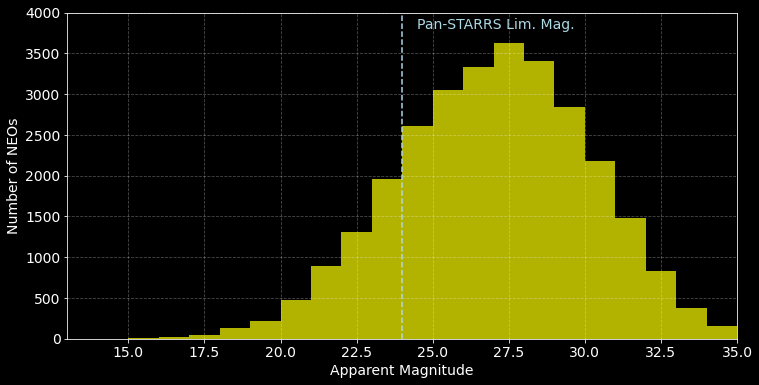

In [16]:
# Now let's plot the distribution of the app. mag.
# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(neo_df["app_mag"],
                           bins=np.arange(13.0, 36.0, 1.0),
                           color="yellow",
                           alpha=0.7)

plt.grid(linestyle="dashed", alpha=0.3)
plt.xlim(13, 35)
plt.xlabel("Apparent Magnitude")
plt.ylabel("Number of NEOs")
plt.ylim(0, 4000)

# Add the limiting magnitude of Pan-STARSS as a vertical line
# https://panstarrs.ifa.hawaii.edu/pswww/?page_id=34
plt.vlines(24, 0, 4000, linestyles="dashed", color="lightblue")
plt.text(24.5, 3800, "Pan-STARRS Lim. Mag.", color="lightblue")

In [17]:
print(f"Number of NEOs Pan-STARRS could observe today: {int(sum(counts[:11]))}")
print(f"Number of NEOs Pan-STARRS could NOT observe today: {int(sum(counts[11:]))}")

Number of NEOs Pan-STARRS could observe today: 5048
Number of NEOs Pan-STARRS could NOT observe today: 23906


# What's next?

Our next session will continue with cell #18 (a new notebook will be created though).